# Final Project
## Group Members: Jesse Zou, Andy Li, Yuhan Zheng, Zhiyao Bao

# Introduction

* What is the data science problem you are trying to solve?
    * We're trying to predict the trend of the stock market (if the stock market's price will go up or go down in general for the next day) for DOW30, SP500 and NASDAQ respectively.
* Why does the problem matter?
    * First, we will be able to have an unbiased analysis on the market and the economy. The stock market is influenced by human emotions and irrational sentiments. By being able to predict micro-movements in the market prices, we are able to also model human behavior. Additionally, it may help people involved in day trading to earn money. 
* What could the results of your predictive model be used for?
    * The model can be used by people who trade in the stock market to make better decisions and potentially generate more profit on their investments.
* Why would we want to be able to predict the thing you’re trying to predict?
    * We want to be able to predict the stock market prices because it helps us to better understand the stock market.
* Then describe the dataset that you will use to tackle this problem
    * The dataset contains a data point for each day of the SP500, DOW30, and NASDAQ. These are stock indexes, that is, a sort of average for the entire stock market. By doing an analysis on this dataset, we are capturing the entire market and economy as a whole.

In [1]:
# Imports
import warnings
#warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
%matplotlib inline

# Load datasets

We first cache the data sets here for continuous usage, taking away overhead that would happen from loading in the data set at each step of the training.

In [3]:
# Read data
data_dow = pd.read_csv("DOW30.csv")
data_sp = pd.read_csv("SP500.csv")
data_nas = pd.read_csv("NASDAQ.csv")

# Data Cleaning

Before performing data cleaning, we first verify whether or not it is even necessary. Some data sets come fully intact without inconsistencies, so we check if the data sets contain any null values before continuing on.

In [4]:
def need_data_cleaning():
    if data_dow.isnull().values.any() or data_sp.isnull().values.any() or data_nas.isnull().values.any():
        print("has None value in dataset")
    else:
        print("do not need data cleaning")

need_data_cleaning()

do not need data cleaning


We got "do not need data cleaning", which means there is no "Null" value in any of those three datasets we are going to use (DOW30.csv, SP500.csv, and NASDAQ.csv). In this case, we can conclude that our datasets are good and no further data cleaning is needed.

# Data Exploration

The data was then explored by using a box plot. 

Using the box plot, the data set can be summarized into its minimum, 1st quartile, median, 3rd quartile, and maximum, along with any outliers that are contained in the data.

In [14]:
# check attributes in each dataset
print("Attributes in DOW30 dataset:")
print(data_dow.columns.values)

print("\nAttributes in SP500 dataset:")
print(data_sp.columns.values)

print("\nAttributes in NASDAQ dataset:")
print(data_nas.columns.values)

Attributes in DOW30 dataset:
['Date' 'LABEL' 'Open' 'High' 'Low' 'Close' 'Volume' 'InterestRate'
 'ExchangeRate' 'VIX' 'Gold' 'Oil' 'TEDSpread' 'EFFR']

Attributes in SP500 dataset:
['Date' 'LABEL' 'Open' 'High' 'Low' 'Close' 'Volume' 'InterestRate'
 'ExchangeRate' 'VIX' 'Gold' 'Oil' 'TEDSpread' 'EFFR']

Attributes in NASDAQ dataset:
['Date' 'LABEL' 'Open' 'High' 'Low' 'Close' 'Volume' 'InterestRate'
 'ExchangeRate' 'VIX' 'Gold' 'Oil' 'TEDSpread' 'EFFR']


In [15]:
# check for class inbalance in each dataset
groups = data_dow['LABEL'].value_counts()
print(groups)
groups = data_sp['LABEL'].value_counts()
print(groups)
groups = data_nas['LABEL'].value_counts()
print(groups)
print("\nThere isn't a class inbalance since the amount of data with label 1 and label 0 are relatively close in each dataset.")

1    1328
0    1120
Name: LABEL, dtype: int64
1    1340
0    1108
Name: LABEL, dtype: int64
1    1363
0    1085
Name: LABEL, dtype: int64

There isn't a class inbalance since the amount of data with label 1 and label 0 are relatively close in each dataset.


In [7]:
# get stats on each attribute in DOW30
data_dow.describe()

,LABEL,Open,High,Low,Close,Volume,InterestRate,ExchangeRate,VIX,Gold,Oil,TEDSpread,EFFR
count,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000,2.448000e+03,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000
mean,0.542484,14776.818372,14858.314373,14691.128288,14779.709081,1.860912e+08,1.758832,1.281169,19.887296,1274.313991,75.563137,0.415776,0.382831
std,0.498294,4223.631326,4220.319281,4228.302892,4224.400625,1.104695e+08,0.623806,0.130193,9.988958,241.554767,24.673508,0.457680,0.516170
min,0.000000,6547.009766,6709.609863,6469.950195,6547.049805,8.410000e+06,0.470000,1.037500,9.140000,692.500000,26.190000,0.090000,0.040000
25%,0.000000,11406.242188,11479.565182,11301.890380,11408.205080,1.032550e+08,1.310000,1.157950,13.547500,1144.875000,50.805000,0.210000,0.110000
50%,1.000000,14548.929690,14586.964845,14464.049805,14555.000000,1.513600e+08,1.715000,1.301650,16.920000,1258.425000,78.495000,0.270000,0.150000
75%,1.000000,17724.763185,17797.615230,17629.057132,17723.240235,2.406975e+08,2.330000,1.367925,22.510000,1374.500000,96.170000,0.400000,0.370000
max,1.000000,26584.279300,26616.710940,26435.339840,26616.710940,8.239400e+08,2.910000,1.601000,80.860000,1891.000000,145.310000,4.580000,2.970000


In [8]:
# get stats on each attribute in SP500
data_sp.describe()

,LABEL,Open,High,Low,Close,Volume,InterestRate,ExchangeRate,VIX,Gold,Oil,TEDSpread,EFFR
count,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000,2.448000e+03,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000
mean,0.547386,1646.084974,1655.057860,1636.358207,1646.369387,4.068707e+09,1.758832,1.281169,19.887296,1274.313991,75.563137,0.415776,0.382831
std,0.497851,510.627540,510.191819,511.150630,510.731453,1.160253e+09,0.623806,0.130193,9.988958,241.554767,24.673508,0.457680,0.516170
min,0.000000,679.280029,695.270020,666.789978,676.530029,1.030000e+09,0.470000,1.037500,9.140000,692.500000,26.190000,0.090000,0.040000
25%,0.000000,1224.319977,1237.059997,1212.862488,1224.562470,3.349525e+09,1.310000,1.157950,13.547500,1144.875000,50.805000,0.210000,0.110000
50%,1.000000,1557.799988,1563.784973,1549.215027,1559.344971,3.790120e+09,1.715000,1.301650,16.920000,1258.425000,78.495000,0.270000,0.150000
75%,1.000000,2070.022461,2078.302490,2058.302491,2069.719910,4.514835e+09,2.330000,1.367925,22.510000,1374.500000,96.170000,0.400000,0.370000
max,1.000000,2867.229980,2872.870117,2851.479980,2872.870117,1.145623e+10,2.910000,1.601000,80.860000,1891.000000,145.310000,4.580000,2.970000


In [9]:
# get stats on each attribute in NASDAQ
data_nas.describe()

,LABEL,Open,High,Low,Close,Volume,InterestRate,ExchangeRate,VIX,Gold,Oil,TEDSpread,EFFR
count,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000,2.448000e+03,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000
mean,0.556781,3724.890605,3745.813435,3701.598365,3725.518689,1.974838e+09,1.758832,1.281169,19.887296,1274.313991,75.563137,0.415776,0.382831
std,0.496867,1503.781242,1506.786726,1500.069431,1503.920815,4.052348e+08,0.623806,0.130193,9.988958,241.554767,24.673508,0.457680,0.516170
min,0.000000,1284.839966,1316.150024,1265.520020,1268.640015,0.000000e+00,0.470000,1.037500,9.140000,692.500000,26.190000,0.090000,0.040000
25%,0.000000,2456.569946,2483.117431,2440.387512,2467.264953,1.739918e+09,1.310000,1.157950,13.547500,1144.875000,50.805000,0.210000,0.110000
50%,1.000000,3245.350098,3252.900024,3228.904908,3244.685059,1.919330e+09,1.715000,1.301650,16.920000,1258.425000,78.495000,0.270000,0.150000
75%,1.000000,4893.767334,4909.544922,4871.697388,4894.100098,2.150585e+09,2.330000,1.367925,22.510000,1374.500000,96.170000,0.400000,0.370000
max,1.000000,7627.520020,7637.270020,7563.439941,7588.319824,4.553600e+09,2.910000,1.601000,80.860000,1891.000000,145.310000,4.580000,2.970000


In [10]:
# Helper functions for visualizatin of data
def box_plot(x, col_name):
    red_square = dict(markerfacecolor='r', marker='s')
    fig, ax = plt.subplots()
    ax.set_title(col_name)
    data = []
    for df in x:
        data.append(df[col_name])
    ax.boxplot(data, vert=False, flierprops=red_square)

def line_graph(x, y):
    pass

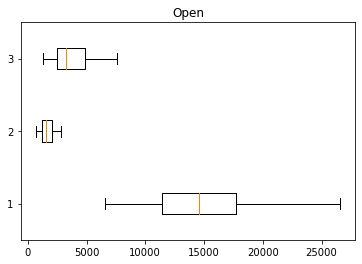

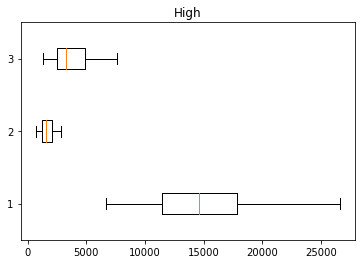

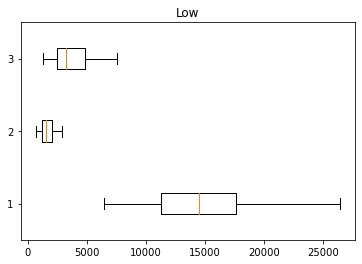

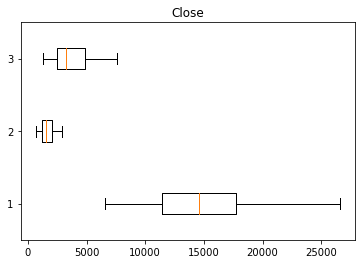

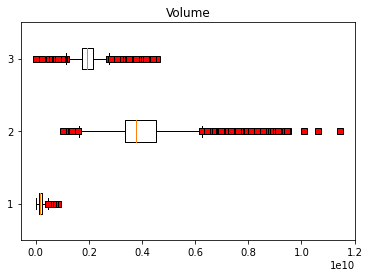

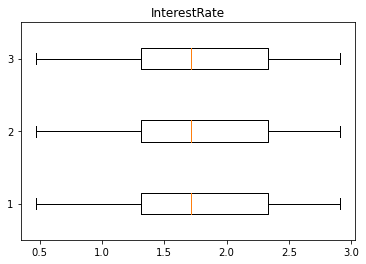

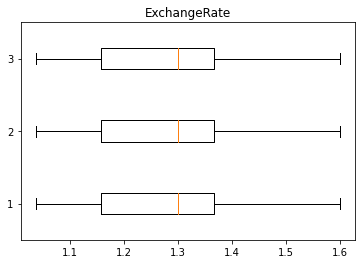

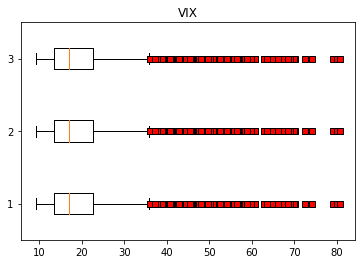

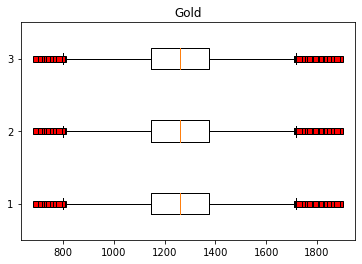

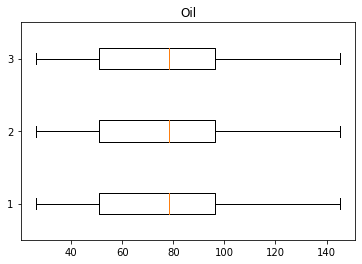

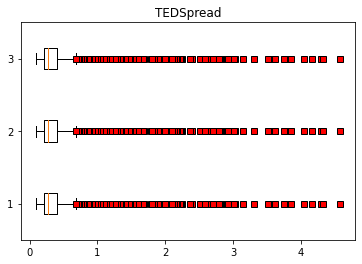

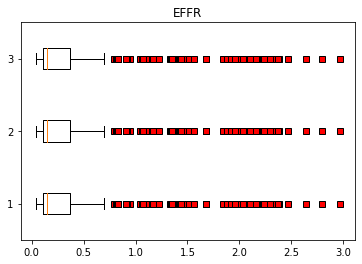

In [11]:
# compare attributes' distribution of value
data_dow_show = data_dow.drop(['Date','LABEL'],axis=1)
data_sp_show = data_sp.drop(['Date','LABEL'],axis=1)
data_nas_show = data_nas.drop(['Date','LABEL'],axis=1)

for column in data_dow_show:
    box_plot([data_dow_show,data_sp_show,data_nas_show], column)

We see outliers in the following attributes: Volume, VIX, Gold, TEDSpread, and EFFR.
We decide to keep the outliers in the datasets since they are all part of the natural fluctuation of stock market.

Based on the above boxplots, we can see that these three datasets, which represent three different stock market, have very different range of stock prices (Open, High, Low, Close) and trading volumns (Volume). Therefore, we cannot combine them into a single dataset and treat it as one market to make prediction on.


# Models

The SVM model performs 3 things:
    
    - Scales the data so that it is normalized to reduce runtime.
    - Performs dimensionality reduction using PCA to reduce runtime.
        - Tries to reduce our dataset to different dimensionalities (1-10) and find the best one
    - Runs SVM
        - Tries to train the model using different kernels ('linear', 'rbf', and 'poly') and find the best one
Using these steps, we can mitigate the time spent training the SVM model without severely impacting the accuracy.

In [ ]:
# SVM
def SVM_trainer(data_X, data_Y):
    svm_scaler = StandardScaler()
    svm_pca = PCA()
    svm = SVC()

    svm_ppl = Pipeline(steps=[('scaler', svm_scaler), ('pca', svm_pca), ('svm', svm)])

    svm_param_grid = {
        'pca__n_components': list(range(1, 11)),
        'svm__kernel': ['linear', 'rbf', 'poly']
    }

    svm_grid_search = GridSearchCV(svm_ppl, svm_param_grid, cv=5, scoring='accuracy')
#     svm_scores = cross_val_score(svm_grid_search, data_X, data_Y, cv=10)
#     svm_preds = cross_val_predict(svm_grid_search, data_X, data_Y, cv=10)
#     print("Accuracy:", svm_scores.mean()*100, "%")
#     print("classification report:\n",classification_report(data_Y, svm_preds))
    return svm_grid_search

# SVM_trainer(data_X, data_Y)

The KNN model performs 3 things:
    
    - Scales the data so that it is normalized to reduce runtime.
    - Performs dimensionality reduction using PCA to reduce runtime.
        - Tries to reduce our dataset to different dimensionalities (1-10) and find the best one
    - Runs KNN
        - Tries to train the model using different numbers of neighbors (1-25) and find the best one
    
Using these steps, we can mitigate the time spent training the SVM model without severely impacting the accuracy.

In [ ]:
# KNN
def KNN_trainer(data_X, data_Y):
    scaler = StandardScaler()
    pca = PCA()
    knn_classifier = KNeighborsClassifier(n_neighbors=7)
    ppl = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('knn', knn_classifier)])
#     scores = cross_val_score(ppl, data_X, data_Y, cv=5) 
#     print("Accuracy:", scores.mean()*100, "%")

    param_grid = {
        'pca__n_components': list(range(1, 11)),
        'knn__n_neighbors': list(range(1, 26))
    }

    knn_grid_search = GridSearchCV(ppl, param_grid, cv=5, scoring='accuracy')
#     knn_grid_search.fit(data_X, data_Y)
#     print("Best parameters:", knn_grid_search.best_params_)
#     print("Best score:", knn_grid_search.best_score_*100, "%")

#     knn_nested_score = cross_val_score(knn_grid_search, data_X, data_Y, cv=5)
#     print("Accuracy:", knn_nested_score.mean()*100, "%")
    return knn_grid_search
# knn_grid_search = KNN_trainer(data_X, data_Y)

The Neural Network model performs 3 things:
    
    - Scales the data so that it is normalized to reduce runtime and to prevent some features from outweighing others.
    - Tests varying hidden layers in order to best determine which would have the greatest performance.
    - Runs Neural Networks.
        - Tests different activation functions ('logistic', 'tanh', and 'relu') to find the best one
Using these steps, we can mitigate the time spent training the Neural Network model without severely impacting the accuracy.

In [3]:
# Neural Network
@ignore_warnings(category=ConvergenceWarning)
def NN_trainer(data_X, data_Y):
    nn_scaler = StandardScaler()
    nn = MLPClassifier()

    nn_ppl = Pipeline(steps=[('scaler', nn_scaler), ('nn', nn)])
    nn_param_grid = {
        'nn__hidden_layer_sizes': list(range(30, 61, 10)),
        'nn__activation': ['logistic', 'tanh', 'relu']
    }
    nn_grid_search = GridSearchCV(nn_ppl, nn_param_grid, cv=5, scoring='accuracy')
#     nn_scores = cross_val_score(nn_grid_search, data_X, data_Y, cv=5)
#     print("Accuracy:", nn_scores.mean()*100, "%")
    return nn_grid_search

# nn_grid_search = NN_trainer(nn_ppl, nn_param_grid, data_X, data_Y)

The Ensamble model 
- combines our SVM model, KNN model and Neural Network model.
- uses the prediction from each of the three models as a vote, and it takes the majority vote as its final prediction.

In [4]:
# Ensamble
@ignore_warnings(category=ConvergenceWarning)
def ensamble_trainer(svm_grid_search, knn_grid_search, nn_grid_search, data_X, data_Y):
    eclf = VotingClassifier(
        estimators=[('svm', svm_grid_search), ('knn', knn_grid_search), ('nn', nn_grid_search)],
        voting='hard')
    for clf, label in zip([svm_grid_search, knn_grid_search, nn_grid_search, eclf], ['SVM', 'KNN', 'Neural Network', 'Ensemble']):
        scores = cross_val_score(clf, data_X, data_Y, scoring='accuracy', cv=5)
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
        
# ensamble_trainer(svm_grid_search, knn_grid_search, nn_grid_search, eclf)

# Results with Various Feature Engineering

In [ ]:
## Add precision if we have time

### We tried three different feature engineerings. 

## 1: without tracking the prev day; no date, TEDSpread, EFFR
* In the first one, we removed the date since we want to see whether we can get good prediction results assuming each day’s stock price is independent from the previous days. We also removed TEDSpred and EFFR features since initially we believe they are not quite related to the prediction of the stock price.

In [ ]:
# DOW30
data_dow_processed = data_dow.drop(['Date', 'TEDSpread', 'EFFR'],axis=1)
# data_dow_processed.head()
data_dow_Y = data_dow_processed['LABEL']
data_dow_X = data_dow_processed.drop(['LABEL'],axis=1)
svm_grid_search = SVM_trainer(data_dow_X, data_dow_Y)
knn_grid_search = KNN_trainer(data_dow_X, data_dow_Y)
nn_grid_search = NN_trainer(data_dow_X, data_dow_Y)
ensamble_trainer(svm_grid_search, knn_grid_search, nn_grid_search, data_dow_X, data_dow_Y)

##### Results
    Accuracy: 0.54 (+/- 0.00) [SVM]
    Accuracy: 0.50 (+/- 0.03) [KNN]
    Accuracy: 0.52 (+/- 0.04) [Neural Network]
    Accuracy: 0.53 (+/- 0.03) [Ensemble]

In [ ]:
# SP500
data_sp_processed = data_sp.drop(['Date', 'TEDSpread', 'EFFR'],axis=1)
data_sp_Y = data_sp_processed['LABEL']
data_sp_X = data_sp_processed.drop(['LABEL'],axis=1)
svm_grid_search = SVM_trainer(data_sp_X, data_sp_Y)
knn_grid_search = KNN_trainer(data_sp_X, data_sp_Y)
nn_grid_search = NN_trainer(data_sp_X, data_sp_Y)
ensamble_trainer(svm_grid_search, knn_grid_search, nn_grid_search, data_sp_X, data_sp_Y)

##### Results
    Accuracy: 0.53 (+/- 0.04) [SVM]
    Accuracy: 0.50 (+/- 0.02) [KNN]
    Accuracy: 0.53 (+/- 0.03) [Neural Network]
    Accuracy: 0.51 (+/- 0.04) [Ensemble]

In [ ]:
# NASDAQ
data_nas_processed = data_nas.drop(['Date', 'TEDSpread', 'EFFR'],axis=1)
data_nas_Y = data_nas_processed['LABEL']
data_nas_X = data_nas_processed.drop(['LABEL'],axis=1)
SVM_trainer(data_nas_X, data_nas_Y)
svm_grid_search = SVM_trainer(data_nas_X, data_nas_Y)
knn_grid_search = KNN_trainer(data_nas_X, data_nas_Y)
nn_grid_search = NN_trainer(data_nas_X, data_nas_Y)
ensamble_trainer(svm_grid_search, knn_grid_search, nn_grid_search, data_nas_X, data_nas_Y)

##### Results
    Accuracy: 0.56 (+/- 0.00) [SVM]
    Accuracy: 0.47 (+/- 0.04) [KNN]
    Accuracy: 0.56 (+/- 0.00) [Neural Network]
    Accuracy: 0.55 (+/- 0.00) [Ensemble]

## 2: tracking the prev day; no date, TEDSpread, EFFR
* In the second one, we added the predictions of the previous day of the other two datasets, and we removed the date, TEDSpred, and EFFR as we did in the first. Comparing the first and the second, we are able to conclude if adding the predictions of the previous day of the other two datasets would improve accuracy.

In [ ]:
# preprocess data
def process_data(target_dataset, dataset_label1, dataset_label2, label1, label2):
    data_processed = target_dataset.drop(['Date', 'TEDSpread', 'EFFR'],axis=1)
    labels1 = dataset_label1.iloc[0:, 1]
    labels2 = dataset_label2.iloc[0:, 1]
    data_processed[label1] = labels1
    data_processed[label1] = data_processed[label1].shift(periods=1, fill_value=-1)
    data_processed[label2] = labels2
    data_processed[label2] = data_processed[label2].shift(periods=1, fill_value=-1)
    data_processed = data_processed.iloc[1: , :]
    return data_processed

In [ ]:
# DOW30
data_dow_processed = process_data(data_dow, data_sp, data_nas, "SP500", "NASDAQ")
# print(data_dow_processed.head())
data_dow_Y = data_dow_processed['LABEL']
data_dow_X = data_dow_processed.drop(['LABEL'],axis=1)
svm_grid_search = SVM_trainer(data_dow_X, data_dow_Y)
knn_grid_search = KNN_trainer(data_dow_X, data_dow_Y)
nn_grid_search = NN_trainer(data_dow_X, data_dow_Y)
ensamble_trainer(svm_grid_search, knn_grid_search, nn_grid_search, data_dow_X, data_dow_Y)

##### Results
    Accuracy: 0.53 (+/- 0.01) [SVM]
    Accuracy: 0.51 (+/- 0.03) [KNN]
    Accuracy: 0.52 (+/- 0.03) [Neural Network]
    Accuracy: 0.53 (+/- 0.02) [Ensemble]

In [ ]:
# SP500
data_sp_processed = process_data(data_sp, data_dow, data_nas, "DOW30", "NASDAQ")
data_sp_Y = data_sp_processed['LABEL']
data_sp_X = data_sp_processed.drop(['LABEL'],axis=1)
svm_grid_search = SVM_trainer(data_sp_X, data_sp_Y)
knn_grid_search = KNN_trainer(data_sp_X, data_sp_Y)
nn_grid_search = NN_trainer(data_sp_X, data_sp_Y)
ensamble_trainer(svm_grid_search, knn_grid_search, nn_grid_search, data_sp_X, data_sp_Y)

##### Results
    Accuracy: 0.55 (+/- 0.00) [SVM]
    Accuracy: 0.50 (+/- 0.02) [KNN]
    Accuracy: 0.54 (+/- 0.01) [Neural Network]
    Accuracy: 0.54 (+/- 0.01) [Ensemble]

In [ ]:
# NASDAQ
data_nas_processed = process_data(data_nas, data_dow, data_sp, "DOW30", "SP500")
data_nas_Y = data_nas_processed['LABEL']
data_nas_X = data_nas_processed.drop(['LABEL'],axis=1)
SVM_trainer(data_nas_X, data_nas_Y)
svm_grid_search = SVM_trainer(data_nas_X, data_nas_Y)
knn_grid_search = KNN_trainer(data_nas_X, data_nas_Y)
nn_grid_search = NN_trainer(data_nas_X, data_nas_Y)
ensamble_trainer(svm_grid_search, knn_grid_search, nn_grid_search, data_nas_X, data_nas_Y)

##### Results
    Accuracy: 0.55 (+/- 0.02) [SVM]
    Accuracy: 0.50 (+/- 0.04) [KNN]
    Accuracy: 0.56 (+/- 0.00) [Neural Network]
    Accuracy: 0.54 (+/- 0.02) [Ensemble]

## 3: tracking the prev day; no date
* In the third one, we added the predictions of the previous day of the other two datasets, and we only removed the date. Comparing the second and third, we are able to conclude if adding TEDSpred, and EFFR features would improve accuracy.

In [ ]:
# preprocess data
def process_data_2(target_dataset, dataset_label1, dataset_label2, label1, label2):
    data_processed = target_dataset.drop(['Date'],axis=1)
    labels1 = dataset_label1.iloc[0:, 1]
    labels2 = dataset_label2.iloc[0:, 1]
    data_processed[label1] = labels1
    data_processed[label1] = data_processed[label1].shift(periods=1, fill_value=-1)
    data_processed[label2] = labels2
    data_processed[label2] = data_processed[label2].shift(periods=1, fill_value=-1)
    data_processed = data_processed.iloc[1: , :]
    return data_processed

In [ ]:
# DOW30
data_dow_processed = process_data_2(data_dow, data_sp, data_nas, "SP500", "NASDAQ")
# print(data_dow_processed.head())
data_dow_Y = data_dow_processed['LABEL']
data_dow_X = data_dow_processed.drop(['LABEL'],axis=1)
svm_grid_search = SVM_trainer(data_dow_X, data_dow_Y)
knn_grid_search = KNN_trainer(data_dow_X, data_dow_Y)
nn_grid_search = NN_trainer(data_dow_X, data_dow_Y)
ensamble_trainer(svm_grid_search, knn_grid_search, nn_grid_search, data_dow_X, data_dow_Y)

##### Results
    Accuracy: 0.54 (+/- 0.01) [SVM]
    Accuracy: 0.50 (+/- 0.03) [KNN]
    Accuracy: 0.53 (+/- 0.03) [Neural Network]
    Accuracy: 0.53 (+/- 0.02) [Ensemble]

In [ ]:
# SP500
data_sp_processed = process_data_2(data_sp, data_dow, data_nas, "DOW30", "NASDAQ")
data_sp_Y = data_sp_processed['LABEL']
data_sp_X = data_sp_processed.drop(['LABEL'],axis=1)
svm_grid_search = SVM_trainer(data_sp_X, data_sp_Y)
knn_grid_search = KNN_trainer(data_sp_X, data_sp_Y)
nn_grid_search = NN_trainer(data_sp_X, data_sp_Y)
ensamble_trainer(svm_grid_search, knn_grid_search, nn_grid_search, data_sp_X, data_sp_Y)

##### Results
    Accuracy: 0.55 (+/- 0.00) [SVM]
    Accuracy: 0.50 (+/- 0.02) [KNN]
    Accuracy: 0.53 (+/- 0.03) [Neural Network]
    Accuracy: 0.53 (+/- 0.02) [Ensemble]

In [ ]:
# NASDAQ
data_nas_processed = process_data_2(data_nas, data_dow, data_sp, "DOW30", "SP500")
data_nas_Y = data_nas_processed['LABEL']
data_nas_X = data_nas_processed.drop(['LABEL'],axis=1)
SVM_trainer(data_nas_X, data_nas_Y)
svm_grid_search = SVM_trainer(data_nas_X, data_nas_Y)
knn_grid_search = KNN_trainer(data_nas_X, data_nas_Y)
nn_grid_search = NN_trainer(data_nas_X, data_nas_Y)
ensamble_trainer(svm_grid_search, knn_grid_search, nn_grid_search, data_nas_X, data_nas_Y)

##### Results
    Accuracy: 0.55 (+/- 0.02) [SVM]
    Accuracy: 0.48 (+/- 0.05) [KNN]
    Accuracy: 0.55 (+/- 0.01) [Neural Network]
    Accuracy: 0.54 (+/- 0.02) [Ensemble]

# Results Analysis

### Compare results on each dataset

In [16]:
## TODO bar graph

To imporove our results, we tried different feature engineerings and different models. For each model, we tried to find the best hyperparameters. Although the final models don’t have a perfect performance, they have already been improved from the original models with accuracies of ~49%.


Among the final models:
- For DOW30, feature engineering 3 performs the best. Among all methods, SVM generates the best accuracy, 54%.
- For SP500, feature engineering 2 performs the best. Among all methods, SVM generates the best accuracy, 55%.
- For NASDAQ, feature engineering 1 performs the best. Among all methods, SVM and Neural Network both generate the best accuracies, 56%.


Overall, SVM performs the best and KNN performs the worst.
The model didn’t work very well with our datasets in general. Since stock market price is influenced by a complex set of factors, we may need more data, more features and feature engineerings based on professional knowlegde to build better models.